## Sea ice parcel tracking

Original full notebook at: /ocean/brogalla/GEOTRACES/parcels/trials/sea-ice-CanadaBasin.ipynb

In [1]:
import numpy as np
from datetime import timedelta as delta
import pickle
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import matplotlib
import datetime
from matplotlib.colors import ListedColormap

%matplotlib inline

##### Parameters:

In [2]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# results:
tracking_folder='/ocean/brogalla/GEOTRACES/parcels/trials/'

# colormap:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(117/N, 1, N)
vals_cont[:, 1] = np.linspace(82/N, 1, N)
vals_cont[:, 2] = np.linspace(60/N, 1, N)
sed_cmap = ListedColormap(vals_cont).reversed()

In [3]:
# Define boundary latitudes and longitudes for the Laptev Sea region
trajS_bdy1 = 68; trajN_bdy1 = 74; trajE_bdy1 = -170; trajW_bdy1 = -210;
trajS_bdy2 = 70; trajN_bdy2 = 75; trajE_bdy2 = -185; trajW_bdy2 = -230;

WE_bdy1A = np.linspace(trajW_bdy1, trajE_bdy1, 30)
WE_bdy1B = np.linspace(trajE_bdy2, trajE_bdy1, 30)
WES_bdy1 = np.ones(WE_bdy1A.shape)*trajS_bdy1
WEN_bdy1 = np.ones(WE_bdy1A.shape)*trajN_bdy1

SN_bdy1A = np.linspace(trajS_bdy1, trajS_bdy2, 30)
SN_bdy1B = np.linspace(trajS_bdy1, trajN_bdy1, 30)
SNW_bdy1 = np.ones(SN_bdy1A.shape)*trajW_bdy1
SNE_bdy1 = np.ones(SN_bdy1A.shape)*trajE_bdy1

WE_bdy2A = np.linspace(trajW_bdy2, trajW_bdy1, 30)
WE_bdy2B = np.linspace(trajW_bdy2, trajE_bdy2, 30)
WES_bdy2 = np.ones(WE_bdy2A.shape)*trajS_bdy2
WEN_bdy2 = np.ones(WE_bdy2A.shape)*trajN_bdy2

SN_bdy2A = np.linspace(trajS_bdy2, trajN_bdy2, 30)
SN_bdy2B = np.linspace(trajN_bdy1, trajN_bdy2, 30)
SNW_bdy2 = np.ones(SN_bdy2A.shape)*trajW_bdy2
SNE_bdy2 = np.ones(SN_bdy2A.shape)*trajE_bdy2

##### Functions

In [4]:
def load_tracks(filename):
    nemo_file  = nc.Dataset(filename)

    traj = np.array(nemo_file.variables['trajectory']) # dimensions: number of particles, tracks
    time = np.array(nemo_file.variables['time'])       # units: seconds
    lat  = np.array(nemo_file.variables['lat'])        # degrees North
    lon  = np.array(nemo_file.variables['lon'])        # degrees East

    return traj, time, lon, lat

In [5]:
def parcel_origin(CB_lon, CB_lat, CB_time, CB_traj):

    dim_parc = int((CB_lon.shape[0]/12)/np.ceil(CB_lon.shape[1]/(4*365))) # bottom converts 6 hour to days    
    dim_time = int(12*((CB_lon.shape[0]/dim_parc)/12))

    particles_origin = np.zeros((dim_parc,dim_time))
    # --- Russian shelf in fall = 1
    # --- else = 0

    for release_time in range(0,dim_time):
        for location in range(0,dim_parc):
            ind = location + release_time*dim_parc
            lon_loc = CB_lon[ind,:]
            lat_loc = CB_lat[ind,:]
            time_loc = CB_time[ind,:]
            traj_loc = CB_traj[ind,:]

            Laptev_particle = check_laptev(traj_loc, lon_loc, lat_loc, time_loc)

            if Laptev_particle:
                particles_origin[location, release_time] = 1

    return particles_origin

In [6]:
def check_laptev(CB_traj, CB_lon, CB_lat, CB_time):
    # does the parcel spend time in the laptev sea in the fall?

    Laptev_particle = False
    # At each time step:
    for timestep in range(0,len(CB_traj)):
        if ((CB_lon[timestep]   < trajE_bdy1) & (CB_lon[timestep] > trajW_bdy1) \
            & (CB_lat[timestep] < trajN_bdy1) & (CB_lat[timestep] > trajS_bdy1)) or \
           ((CB_lon[timestep]   < trajE_bdy2) & (CB_lon[timestep] > trajW_bdy2) \
            & (CB_lat[timestep] < trajN_bdy2) & (CB_lat[timestep] > trajS_bdy2)):

            start_time   = datetime.datetime(2015,12,31) - datetime.timedelta(seconds=CB_time[0])
            current_time = start_time - datetime.timedelta(seconds=CB_time[timestep])

            # And is the parcel on the shelf in the fall?
            if current_time.month in [9,10,11,12]:
                Laptev_particle = True
                break
                    
    return Laptev_particle

In [19]:
def drawCirc1(ax,radius,centX,centY,angle_,theta2_,color_='black'):
    #========Create the arrow head
    endX=centX-(radius/2)*np.cos(np.radians(theta2_+angle_)) #Do trig to determine end position
    endY=centY+(radius/2)*np.sin(np.radians(theta2_+angle_))

    #Create triangle as arrow head
    ax.add_patch(matplotlib.patches.RegularPolygon((endX, endY), # (x,y)
            3,                       # number of vertices
            radius/6,                # radius
            np.radians(angle_+theta2_),     # orientation
            color='k', zorder=3))
    ax.add_patch(matplotlib.patches.RegularPolygon((endX, endY), # (x,y)
            3,                       # number of vertices
            radius/9,                # radius
            np.radians(angle_+theta2_),     # orientation
            color=color_, zorder=3))
    
    #========Line
    arc = matplotlib.patches.Arc([centX,centY],radius,radius,angle=angle_,
          theta1=25,theta2=theta2_,linestyle='-',lw=2,color=color_, zorder=3)
    arc2 = matplotlib.patches.Arc([centX,centY],radius,radius,angle=angle_,
          theta1=40,theta2=theta2_+4,linestyle='-',lw=3,color='k', zorder=3)
    ax.add_patch(arc2)
    ax.add_patch(arc)
    
#     ax.set_xlim([centX-radius,centY+radius]) and ax.set_ylim([centY-radius,centY+radius]) 

##### Load files:

In [8]:
mesh = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon = np.array(mesh.variables['nav_lon'])
mesh_lat = np.array(mesh.variables['nav_lat'])

In [9]:
CB_traj, CB_time, CB_lon, CB_lat = load_tracks(tracking_folder+'Particles_CB-20200205-extended-region2.nc')

In [10]:
particles_origin = parcel_origin(CB_lon, CB_lat, CB_time, CB_traj)
dim_parc = int((CB_lon.shape[0]/12)/np.ceil(CB_lon.shape[1]/(4*365)))
dim_lons = len(set(CB_lon[0:dim_parc,0]))

proportion_laptev = np.empty(CB_lon[0:dim_parc,0].shape)

for location in range(0,dim_parc):
    proportion_laptev[location] = np.sum(particles_origin[location,:])/particles_origin.shape[1]

##### Figures

Text(0.5, 1.0, 'Proportion of Siberian tracks')

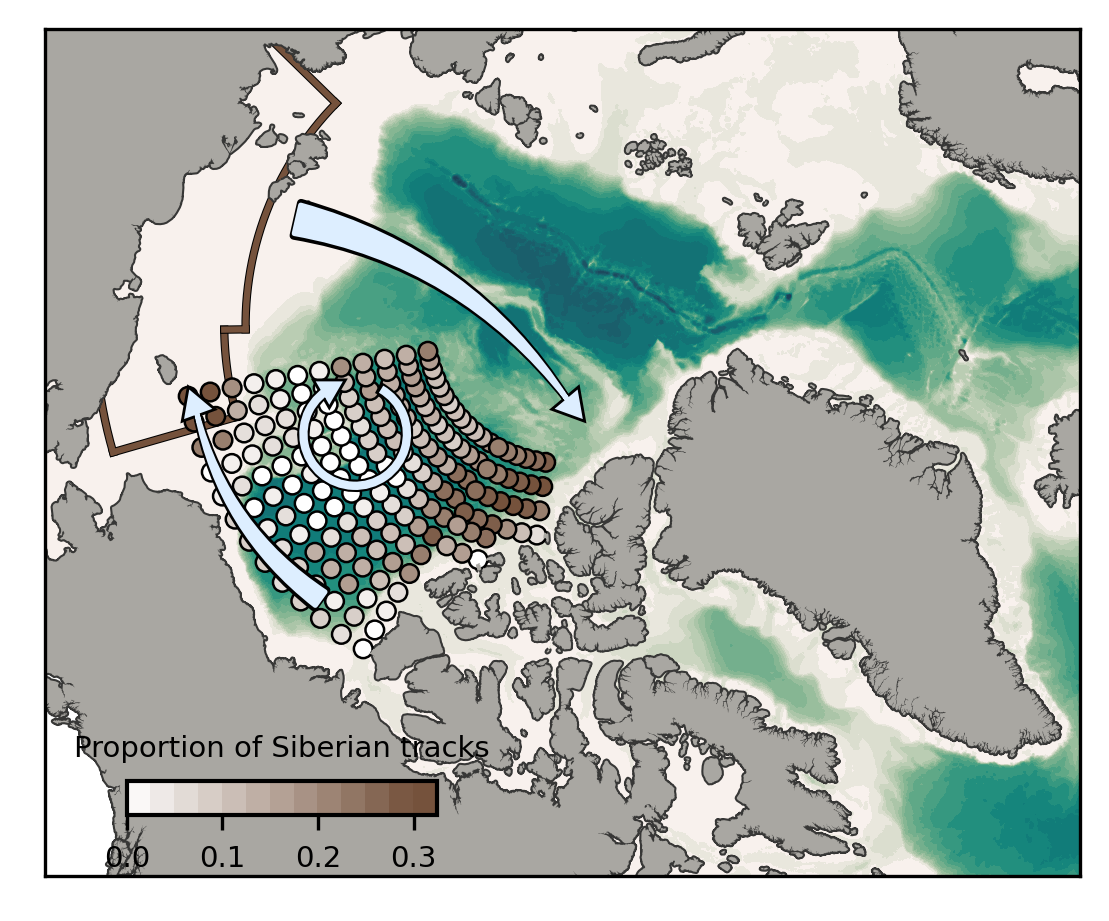

In [28]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/AO-map.pickle','rb'))

# Particle tracks -------------------------------------------------------------------
x_CB, y_CB  = proj1(CB_lon[0:dim_parc,0], CB_lat[0:dim_parc,0])
CB          = proj1.scatter(x_CB, y_CB, s=20, zorder=2, c=proportion_laptev, edgecolor='k', \
                            cmap=sed_cmap, vmin=0, vmax=0.3, linewidths=0.6)
CS1 = proj1.contourf(np.zeros((4,4)), np.zeros((4,4)), np.ones((4,4)),\
                     vmin=0.0, vmax=0.3, levels=np.arange(0,0.35,0.025), cmap=sed_cmap)

levels=np.arange(0,0.45,0.025)

# Siberian shelf boundaries: --------------------------------------------------------
xS1, yS1 = proj1(WE_bdy1A, WES_bdy1); xN1, yN1 = proj1(WE_bdy1B, WEN_bdy1);
xW1, yW1 = proj1(SNW_bdy1, SN_bdy1A); xE1, yE1 = proj1(SNE_bdy1, SN_bdy1B);

xS2, yS2 = proj1(WE_bdy2A, WES_bdy2); xN2, yN2 = proj1(WE_bdy2B, WEN_bdy2); 
xW2, yW2 = proj1(SNW_bdy2, SN_bdy2A); xE2, yE2 = proj1(SNE_bdy2, SN_bdy2B);

color_line1 = '-k'
color_line2 = '-'
linewidth1  = 2.0
linewidth2  = 1.5 

proj1.plot(xS1, yS1, color_line1, linewidth=linewidth1, zorder=1)
proj1.plot(xN1, yN1, color_line1, linewidth=linewidth1, zorder=1)
proj1.plot(xW1, yW1, color_line1, linewidth=linewidth1, zorder=1)
proj1.plot(xE1, yE1, color_line1, linewidth=linewidth1, zorder=1)
proj1.plot(xS1, yS1, color_line2, linewidth=linewidth2, c='#75523C', zorder=1)
proj1.plot(xN1, yN1, color_line2, linewidth=linewidth2, c='#75523C', zorder=1)
proj1.plot(xW1, yW1, color_line2, linewidth=linewidth2, c='#75523C', zorder=1)
proj1.plot(xE1, yE1, color_line2, linewidth=linewidth2, c='#75523C', zorder=1)

proj1.plot(xS2, yS2, color_line1, linewidth=linewidth1, zorder=1)
proj1.plot(xN2, yN2, color_line1, linewidth=linewidth1, zorder=1)
proj1.plot(xW2, yW2, color_line1, linewidth=linewidth1, zorder=1)
proj1.plot(xE2, yE2, color_line1, linewidth=linewidth1, zorder=1)
proj1.plot(xS2, yS2, color_line2, linewidth=linewidth2, c='#75523C', zorder=1)
proj1.plot(xN2, yN2, color_line2, linewidth=linewidth2, c='#75523C', zorder=1)
proj1.plot(xW2, yW2, color_line2, linewidth=linewidth2, c='#75523C', zorder=1)
proj1.plot(xE2, yE2, color_line2, linewidth=linewidth2, c='#75523C', zorder=1)

# Arrows ----------------------------------------------------------------------------
drawCirc1(ax1,0.55e6,1.65e6,2.35e6,90,330, color_='#ddeeff')
TPD2 = matplotlib.patches.FancyArrowPatch((1.3e6, 3.5e6), (2.8e6,2.5e6),\
                                        connectionstyle="arc3,rad=-.2", \
                                        color='k', linewidth=2, \
                                        arrowstyle='wedge, tail_width=8', zorder=3)
TPD = matplotlib.patches.FancyArrowPatch((1.3e6, 3.5e6), (2.8e6,2.5e6),\
                                        connectionstyle="arc3,rad=-.2", \
                                        color='#ddeeff', linewidth=1.2, \
                                        arrowstyle='wedge, tail_width=7', zorder=3)

ax1.add_patch(matplotlib.patches.RegularPolygon((2.8e6,2.5e6), 3, 1e5, np.radians(-20), color='k', zorder=3))
ax1.add_patch(TPD2); ax1.add_patch(TPD);
ax1.add_patch(matplotlib.patches.RegularPolygon((2.8e6,2.5e6), 3, 0.7e5, np.radians(-20), color='#ddeeff', zorder=3))


BS2 = matplotlib.patches.FancyArrowPatch((1.5e6, 1.45e6), (8e5,2.5e6),\
                                        connectionstyle="arc3,rad=-.2", \
                                        color='k', linewidth=2, \
                                        arrowstyle='wedge, tail_width=5', zorder=3)
BS = matplotlib.patches.FancyArrowPatch((1.5e6, 1.45e6), (8e5,2.5e6),\
                                        connectionstyle="arc3,rad=-.2", \
                                        color='#ddeeff', linewidth=1.2, \
                                        arrowstyle='wedge, tail_width=4', zorder=3)
ax1.add_patch(matplotlib.patches.RegularPolygon((8e5,2.5e6), 3, 1e5, np.radians(20), color='k', zorder=3))
ax1.add_patch(BS2); ax1.add_patch(BS);
ax1.add_patch(matplotlib.patches.RegularPolygon((8e5,2.5e6), 3, 0.7e5, np.radians(20), color='#ddeeff', zorder=3))

# Colorbar ---------------------------------------------------------------
# Draw rectangle behind colorbar:
# matplotlib.patches.Rectangle((0, 1), 1, 1, facecolor='w', zorder=3)
# Colorbar
cbaxes = fig.add_axes([0.19,0.18,0.23,0.03]) 
CB1 = plt.colorbar(CS1, cax=cbaxes, orientation='horizontal', ticks=np.arange(0,1.1,0.1))
CB1.ax.tick_params(labelsize=7)
CB1.outline.set_linewidth(1.0)
CB1.ax.set_title('Proportion of Siberian tracks', fontsize=7)

# figure = plt.gcf()
# figure.set_size_inches(4.5*1.5, 3.7*1.5)
# figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202104/M4-tracks_siberian_region.png', \
#                bbox_inches='tight', dpi=300)
# figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202104/M4-tracks_siberian_region.svg', \
#                format='svg', bbox_inches='tight', dpi=300)